<a href="https://colab.research.google.com/github/choi-yh/DataMining/blob/master/Image_Search_AE5_MyPhoto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Data and Library load

In [0]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [0]:
# http://www.robots.ox.ac.uk/~vgg/data/pets/
data = np.load('/gdrive/My Drive/Python/DataMining/Final/Data/MyData.npy')

X = data.astype('float32')

X.shape

(308, 600, 600, 3)

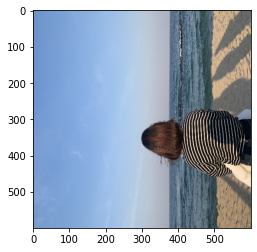

In [0]:
# data check

plt.imshow(X[100].astype('int32'))
plt.show()

### Train and Test data / One-hot encoding / data normalization

In [0]:
# train and test dataset
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(X, random_state=0)

In [0]:
X_train.shape, X_test.shape

((231, 600, 600, 3), (77, 600, 600, 3))

In [0]:
X_train /= 255
X_test /= 255

### Modeling

In [0]:
input_img = layers.Input(shape=(600, 600, 3))
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPool2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPool2D((2, 2), padding='same')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPool2D((2, 2), padding='same', name='encoder')(x)

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = models.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

autoencoder.fit(X_train, X_train, epochs=10, batch_size=5, callbacks=None)

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 600, 600, 3)]     0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 600, 600, 64)      1792      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 300, 300, 64)      0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 300, 300, 32)      18464     
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 300, 300, 32)      9248      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 150, 150, 32)      0         
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 150, 150, 16)      462

### Image Search

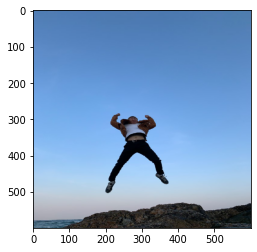

In [0]:
encoder = models.Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('encoder').output)
idx = 76
query = X_train[idx]
plt.imshow(query.reshape(600, 600, 3))

codes = encoder.predict(X_test)
query_code = encoder.predict(query.reshape(1, 600, 600, 3))

In [0]:
from sklearn.neighbors import NearestNeighbors
n_neigh = 7

codes = codes.reshape(-1, 75*75*16)
print('codes.shape: ', codes.shape)
query_code = query_code.reshape(1, 75*75*16)
print('query_code.shape: ', query_code.shape)

nbrs = NearestNeighbors(n_neighbors=n_neigh).fit(codes)

distances, indices = nbrs.kneighbors(np.array(query_code))

closest_images = X_test[indices]

closest_images = closest_images.reshape(-1, 600, 600, 3)
print('closest_image.shape: ', closest_images.shape)
print('')
# print('distance: ', distances)
print('indices: ', indices)

codes.shape:  (77, 90000)
query_code.shape:  (1, 90000)
closest_image.shape:  (7, 600, 600, 3)

indices:  [[43 21 14 60 25 44 66]]


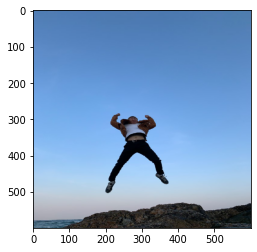

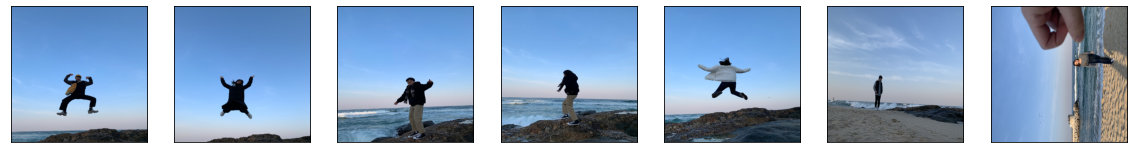

In [0]:
plt.imshow(query.reshape(600, 600, 3))

plt.figure(figsize=(20, 6))
for i in range(n_neigh):
    ax = plt.subplot(1, n_neigh, i+1)
    plt.imshow(closest_images[i].reshape(600, 600, 3))

    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()